## Introduction

The aim of this competition is to predict whether a given transaction is fraudelent or not based on the information given regarding the transaction. Information such as the transaction amount, card type, product category, etc is given.

In this kernel, I will be visualizing and exploring these features in-depth using **seaborn**. I will attempt to make inferences and conlusions based on these graphs and plots.

Then, I will demonstrate how to build models to solve this problem. Specifically, I will be using LightGBM and Neural Network models. I will train these models on the training data, and then finally, I will show how to make predictions on the test data using these trained models.

<center><img src="https://i.imgur.com/K3FE0NA.jpg" width="500px"></center>

<font size=3 color='red'>Please upvote this kernel if you like it :)</font>

## Preparing the ground for analysis

### Import necessary libraries

In [8]:
import os
import pandas as pd

In [1]:

import gc
import numpy as np
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import SVG

import warnings
warnings.filterwarnings('ignore')

import lightgbm
import xgboost
import catboost

import keras
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### Check the files available in the dataset

In [ ]:
os.listdir('.')

### Define the paths for the train and test data

In [11]:
DATA_PATH = './ieee-fraud-detection/'
TRAIN_PATH = DATA_PATH + 'train_transaction.csv'
TEST_PATH = DATA_PATH + 'test_transaction.csv'

### Load the train and test datasets

In [12]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [13]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Replace the NaNs with 0s and check the first few rows

In [5]:
train_df = train_df.fillna(0.0)
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,0.0,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

## Transaction Amounts

As the name suggests, this is the amount of money transferred during the transaction, and this is clearly a continuous variable. I will visualize this feature in relation with the target, *isFraud*.



### Distribution of transaction amounts for non-fraudelent and fraudulent cases

### Violin Plot

In [6]:
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["ytick.labelsize"] = 13

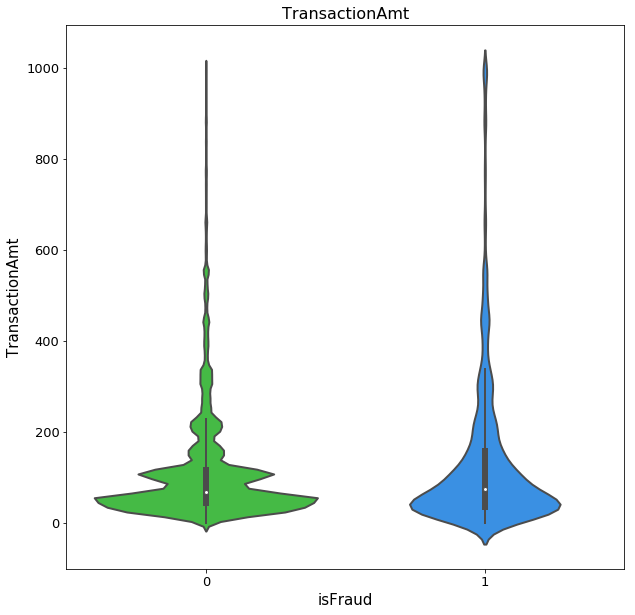

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.violinplot(x="isFraud", y="TransactionAmt", data=train_df.query("TransactionAmt < 1000"), palette=["limegreen", "dodgerblue"], linewidth=2
                      , ax=ax).set_title('TransactionAmt', fontsize=16)
plt.show()

In the violin plot above, the green violin is the distribution of transaction amounts for non-fraudulent samples and the red violin is that for fraudulent samples. It can be seen that both distributions have a strong positive (leftward) skew. But, the red violin has greater probability density towards the higher values of *TransactionAmt* as compared to the green distribution. 

The green distribution has a very high probability denisty concentrated around the lower values of *TransactionAmt* and as a result, the probability density around the higher values of *TransactionAmt* is almost negligible. But, the red violin on the other hand, has lesser probability density concentrated around the lower values of *TransactionAmt* and thus, there is a considerable probability density around the higher values of *TransactionAmt*.

This happens because the green violin has multiple peaks (multimodal characteristic) around the lower values of *TransactionAmt*, whereas the red violin has only one clear peak in this region. This presence of only one peak in the red violin indicates that it has a much milder skew than the green violin. **Therefore, in general, the greater the transaction amount, the more likely it is for the transaction to be fraudulent.**

This makes intuitive sense, because very expensive transactions have a greater chance of being fraudulent than less expensive transactions.




### Box Plot

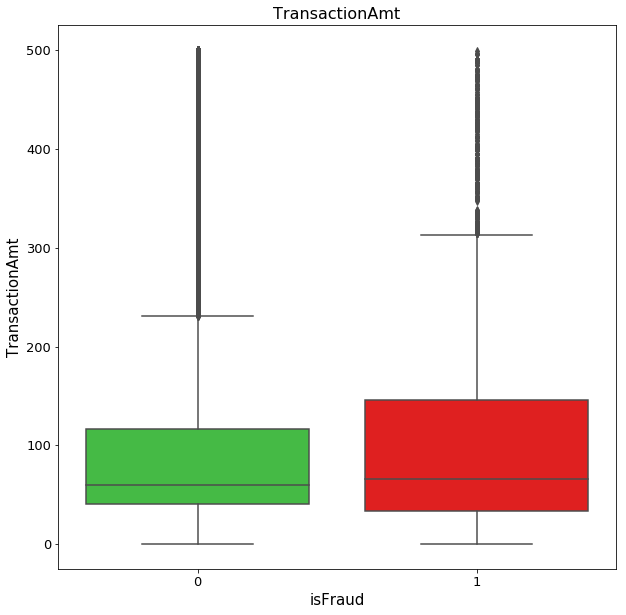

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.boxplot(x="isFraud", y="TransactionAmt", data=train_df.query("TransactionAmt < 500"), palette=["limegreen", "red"], ax=ax).set_title('TransactionAmt', fontsize=16)
plt.show()

The box plot above also suggests that more expensive transactions are more likely to be fraudulent. This can be inferred from the fact that the mean value of the red box is greater than that of the green box. Although the first quartiles of the two distributions are very similar, the third quartile of the red box is significantly greater than that of the green box, providing further evidence that higher transaction amounts are more likely to be fraudulent than not, *i.e.* **the greater the transaction amount, the more likely it is for the transaction to be fraudulent.** 

## Product CD

I am not sure what Product CD exactly means, but it seems to be a categorical variable that provides some information regarding the category of a product. **Products in this dataset come under five broad categories: W, H, C, S, and R.** I will visualize this feature in relation with the target, *isFraud*.

### Frequencies of the different product categories 

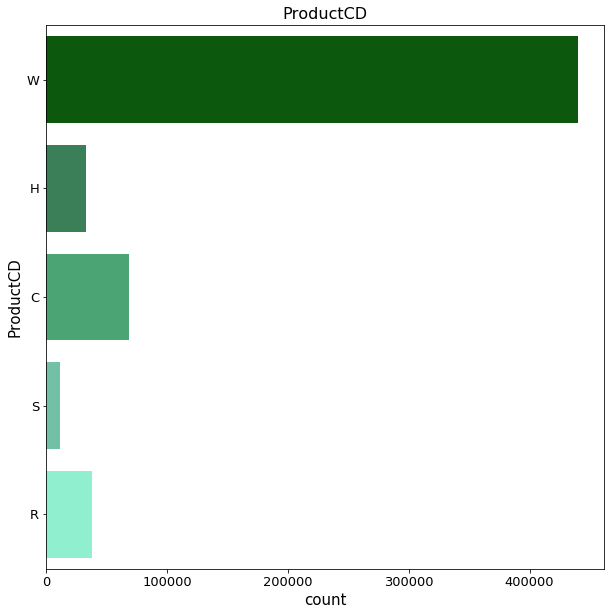

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="ProductCD", data=train_df, palette=reversed(['aquamarine', 'mediumaquamarine', 'mediumseagreen', 'seagreen', 'darkgreen'])).set_title('ProductCD', fontsize=16)
plt.show(plot)

From the above plot, we can clearly see that the most common *ProductCD* value is W. The other four product categories, H, C, S, and R are very rare compared to W. 

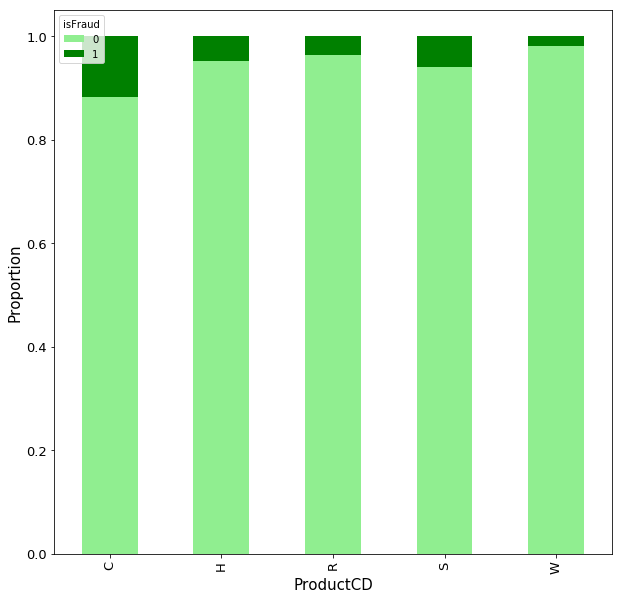

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

props = train_df.query("TransactionAmt < 500")\
                .groupby("ProductCD")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['lightgreen', 'green'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

In the above proportion plot, the height of the dark green bar (at the top) represents the probability of a transaction involving a given product category being fraudulent. We can see that a product of category *C* is more likely to be involved in a fraudulent transaction as compared to any other product category. The next most fraudulence-prone product category is category *S*, and so on.



### Distributions of transaction amounts for different *ProductCD* values (for non-fraudulent and fraudulent cases)

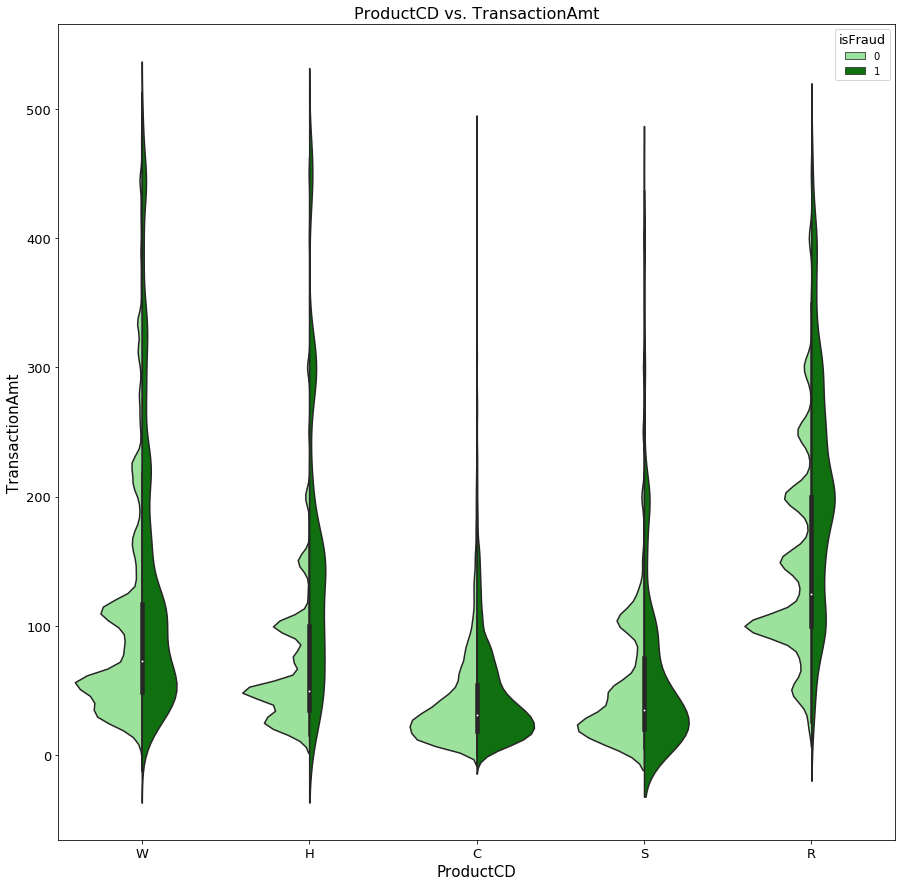

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="ProductCD", y="TransactionAmt", hue="isFraud",
                      data=train_df.query('TransactionAmt < 500'), palette=['lightgreen', 'green'],
                      split=True, ax=ax).set_title('ProductCD vs. TransactionAmt', fontsize=16)

plt.show(plot)

In the above violin plots, the light green sections represent the distribution for non-fraudulent cases and the dark green sections represent the distribution for fraudulent cases. We can see the same trend as before. Both the distributions types have strong positive (leftward) skews. But, the light green (non-fraudulent) distributions have a greater probability density concentrated around the lower values of transaction amounts, once again, because there are several peaks (unlike the dark green distributions).

But, there are a few exceptions to this trend in the above visualization. For example, the non-fraudulent and fraudulent distributions are very similar for the *C* product category. Both the distributions have only one peak and they look very similar in almost every way. Interestingly, the *C* product category also has the highest fraudulence rate, and this is probably the reason why the correlation between the transaction amount and the target is very low for this category.

But, for the rest of the product categories, the trend is roughly followed.

The distributions for the *S* product category seem to have the lowest means and the strongest skews. These distributions have a very high concentration of probability density around the lower values of *TransactionAmt*. Transactions of type *S* tend to have low transaction amounts. On the other side of the spectrum, the distributions for the *R* product category seem to have the highest means and the weakest skews. These distributions have a very even spread and almost no skew. Transactions of type *R* tend to have high transaction amounts.

Maybe, one can create a model that changes the weightage of the *TransactionAmt* feature based on the product category. For example, the weightage of the *TransactionAmt* feature can be reduced for the *C* product category, because the fraudulent and non-fraudulent distributions are very similar for this product category. 

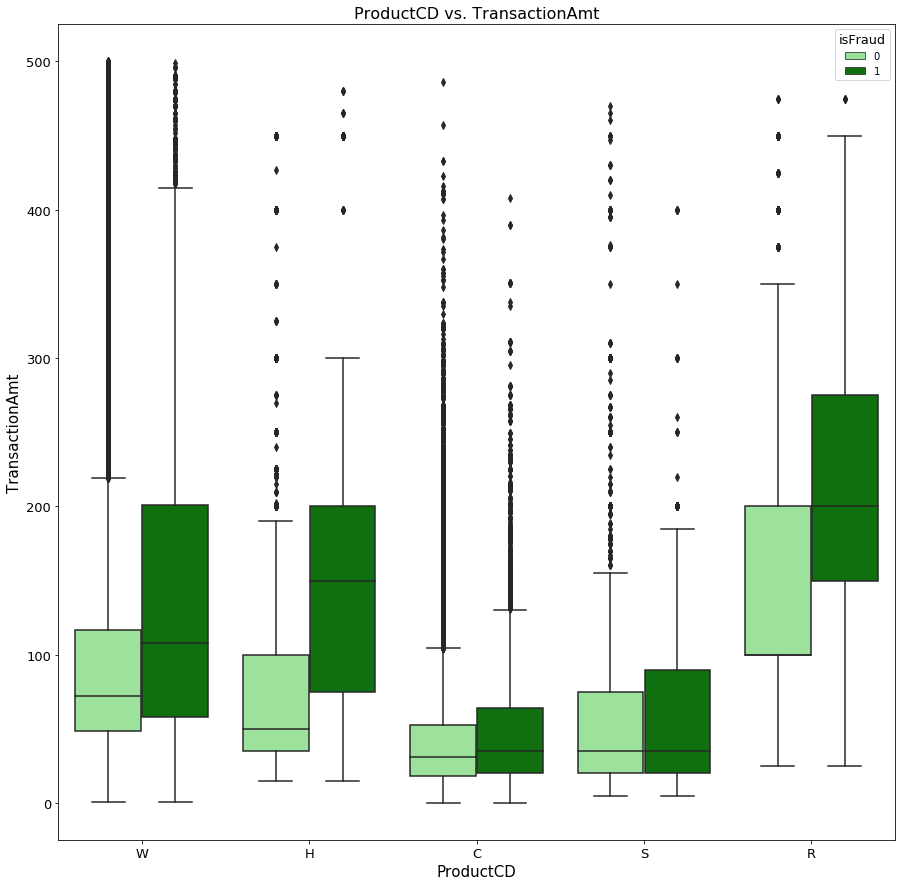

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="ProductCD", y="TransactionAmt", hue="isFraud",
                   data=train_df.query('TransactionAmt < 500'), palette=['lightgreen', 'green'],
                   ax=ax).set_title('ProductCD vs. TransactionAmt', fontsize=16)

plt.show(plot)

The same trends and patterns can be seen in the box plots above. Both the distributions types have strong positive (leftward) skews. But, the light green (non-fraudulent) distributions clearly have lower means as compared to the dark green (fraudulent) distributions.

The same exceptions to this trend can also be seen in the above visualization. For example, the non-fraudulent and fraudulent distributions are very similar for the *C* product category. Both the distributions have similar means, first quartiles, and third quartiles.

## P_emaildomain

The *P_emaildomain* represents the email domain through which the transaction was **payed**. The most common domains are *gmail.com, yahoo.com, hotmail.com, and anonymous.com*.

### Frequencies of the different email domains (P)

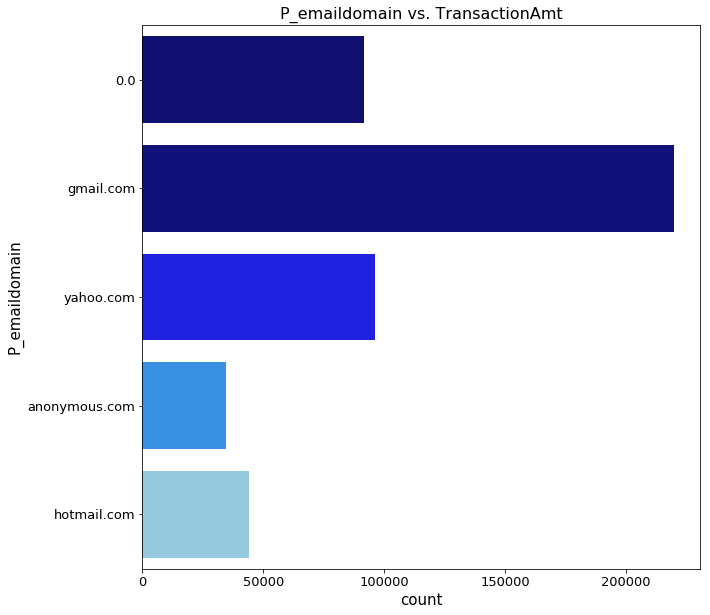

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="P_emaildomain", data=train_df.query("P_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com']").query("TransactionAmt < 500"),
                     palette=['navy', 'darkblue', 'blue', 'dodgerblue', 'skyblue']).set_title('P_emaildomain vs. TransactionAmt', fontsize=16)
plt.show(plot)

From the above plot, we can clearly see that the most common *P_emaildomain* value is *gmail.com*. The next most common email domain (for payment) is *yahoo.com* and the rest are comparatively very rare. 

### Fraudulence Proportion Plot

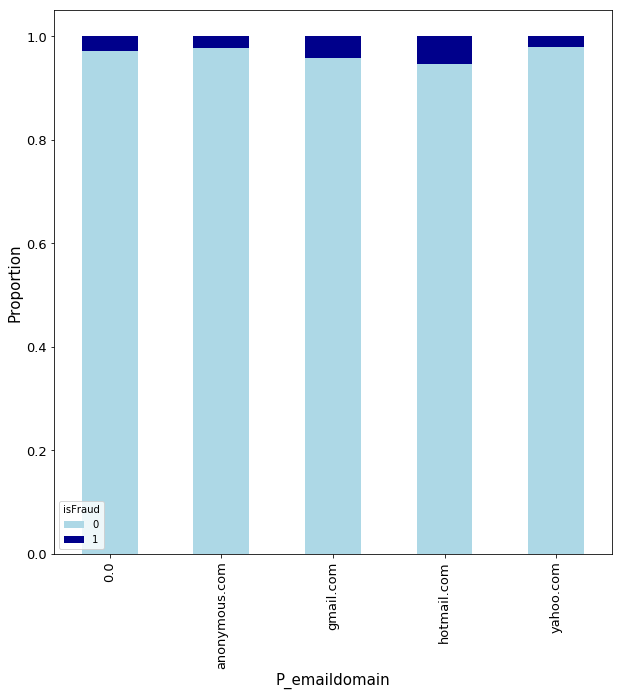

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

props = train_df.query("P_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com']").query("TransactionAmt < 500")\
                .groupby("P_emaildomain")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['lightblue', 'darkblue'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

In the above proportion plot, the height of the dark blue bar (at the top) represents the probability of a transaction made through a given email domain being fraudulent. We can see that an email domain of *hotmail.com* is associated with the highest probability of a fraudulent transaction. The next most fraudulence-prone email domain is *gmail.com*. And, the least fraudulence-prone email domain is *yahoo.com*.  

### TransactionAmt vs. P_emaildomain Violin Plot

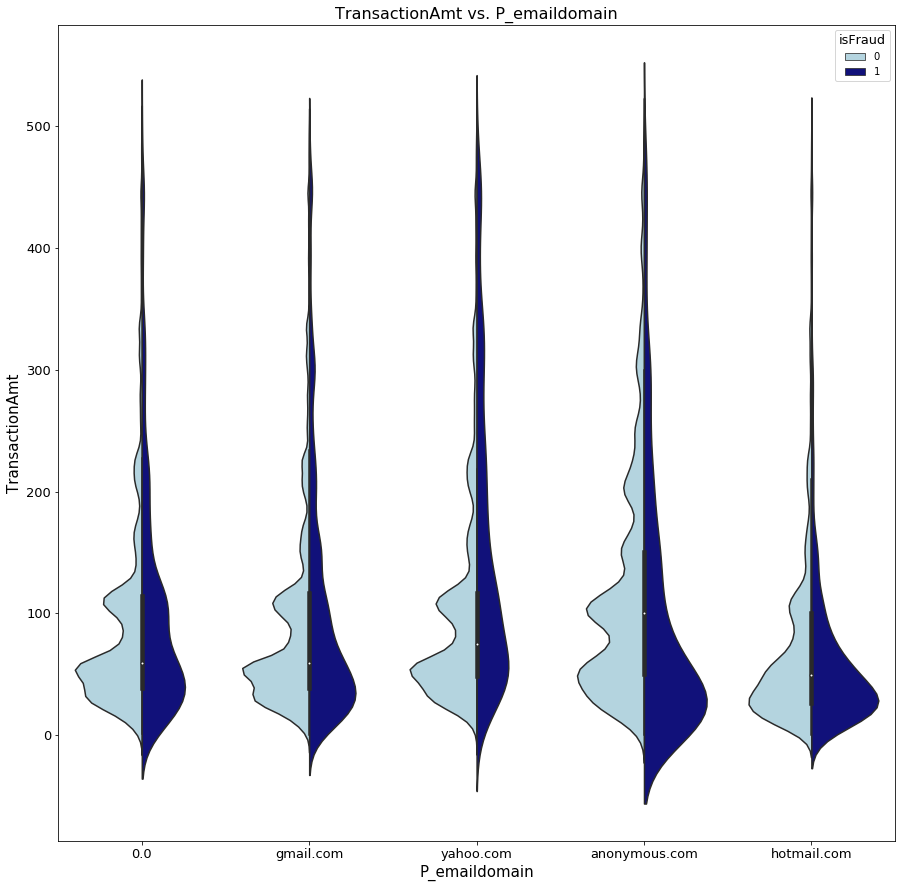

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="P_emaildomain", y="TransactionAmt", hue="isFraud",
                      data=train_df.query("P_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com']").query("TransactionAmt < 500"),
                      palette=['lightblue', 'darkblue'], split=True, ax=ax).set_title('TransactionAmt vs. P_emaildomain', fontsize=16)

plt.show(plot)

In the above violin plots, the light blue sections represent the distribution for non-fraudulent cases and the dark blue sections represent the distribution for fraudulent cases. We can see the same trend as before. Both the distributions types have strong positive (leftward) skews. But, the light blue (non-fraudulent) distributions have a greater probability density concentrated around the lower values of transaction amounts, once again, because there are several peaks (unlike the dark blue distributions).

There are no real exceptions to this trend except for *hotmail.com*. The distributions for transaction amount (for fraudulent and non-fraudulent cases) are very similar at *hotmail.com*. The other domains, namely, *gmail.com, yahoo.com, and anonymous.com* follow the general trend.

Each email domain's distributions are roughly concentrated around the same mean, but with differing variances. No single email domain has a much greater or lower mean than the other email domains.

**Interestingly, once again, the most fraudulence-prone email domain, namely, *hotmail.com* is also the one that does not follow the trend. This is similar to the *C* product category, which was the most fraudulent category and was also the category that did not follow the trend.** 
 

Maybe, one can create a model that changes the weightage of the *TransactionAmt* feature based on the email domain. For example, the weightage of the *TransactionAmt* feature can be reduced for the *hotmail.com* email domain, because the fraudulent and non-fraudulent distributions are very similar for this email domain. 

### TransactionAmt vs. P_emaildomain Box Plot 

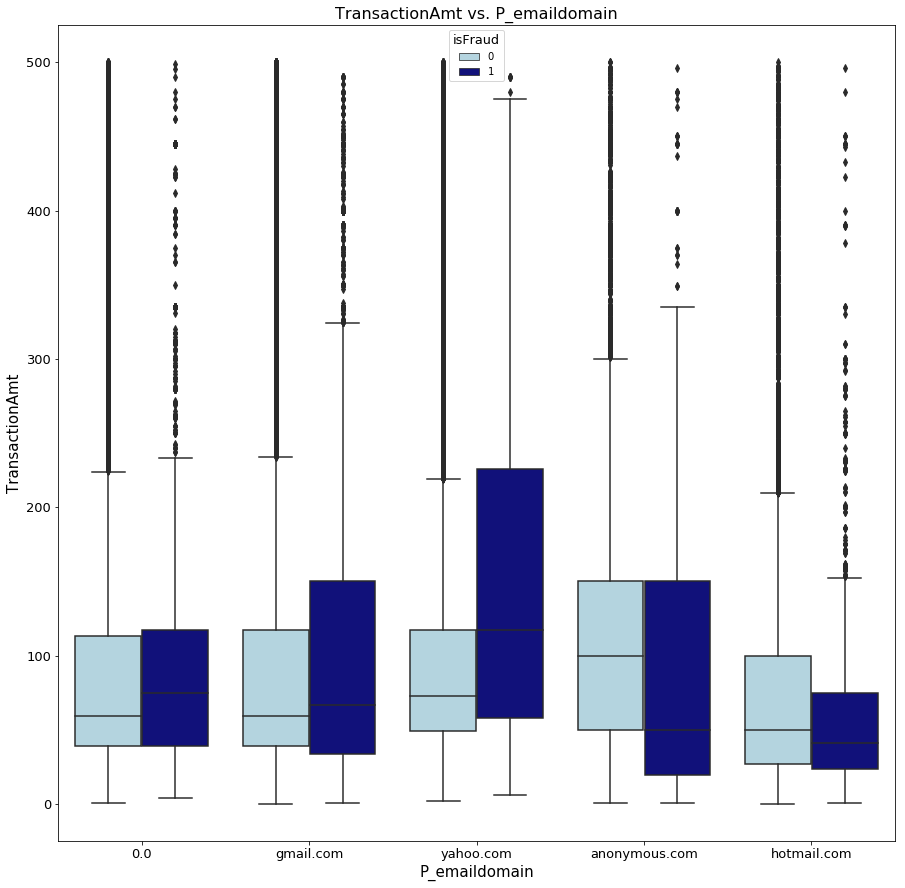

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="P_emaildomain", y="TransactionAmt", hue="isFraud",
                   data=train_df.query("P_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com']").query("TransactionAmt < 500"),
                   palette=['lightblue', 'darkblue'], ax=ax).set_title('TransactionAmt vs. P_emaildomain', fontsize=16)

plt.show(plot)

The same trends and patterns can be seen in the box plots above. Both the distributions types have strong positive (leftward) skews. But, the light blue (non-fraudulent) distributions clearly have lower means as compared to the dark blue (fraudulent) distributions.

The same exceptions to this trend can also be seen in the above visualization. For example, the non-fraudulent and fraudulent distributions are very similar for the *hotmail.com* email domain. Both the distributions have similar means and first quartiles. Although the third quartiles for the *anonymous.com* distributions are very similar, their means are very different.

## R_emaildomain

The *R_emaildomain* represents the email domain through which the transaction was **received**. The most common domains are *gmail.com, yahoo.com, hotmail.com, and anonymous.com*. 

### Frequencies of the different email domains (R)

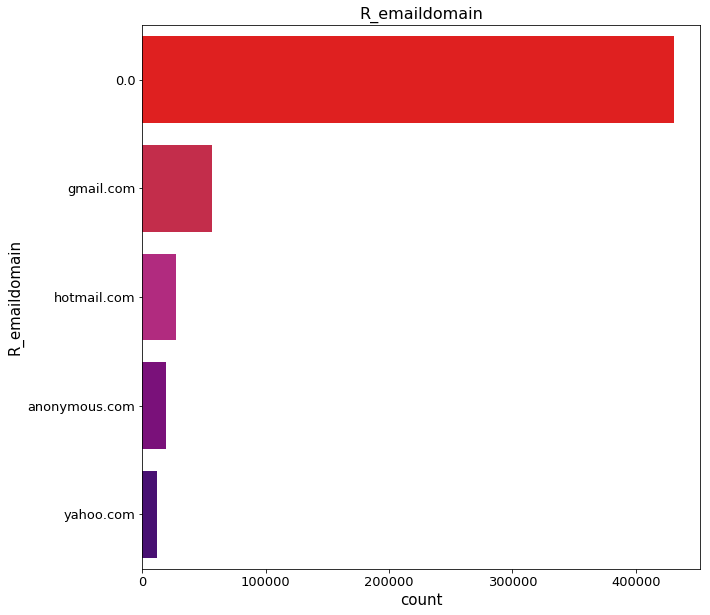

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="R_emaildomain", data=train_df.query("R_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com']").query("TransactionAmt < 500"),
                     palette=['red', 'crimson', 'mediumvioletred', 'darkmagenta', 'indigo']).set_title('R_emaildomain', fontsize=16)
plt.show(plot)

From the above plot, we can clearly see that the most common *R_emaildomain* value is *gmail.com*. The next most common email domain is *hotmail.com*. The least common receiver email domain is *yahoo.com*.

### Fraudulence Proportion Plot

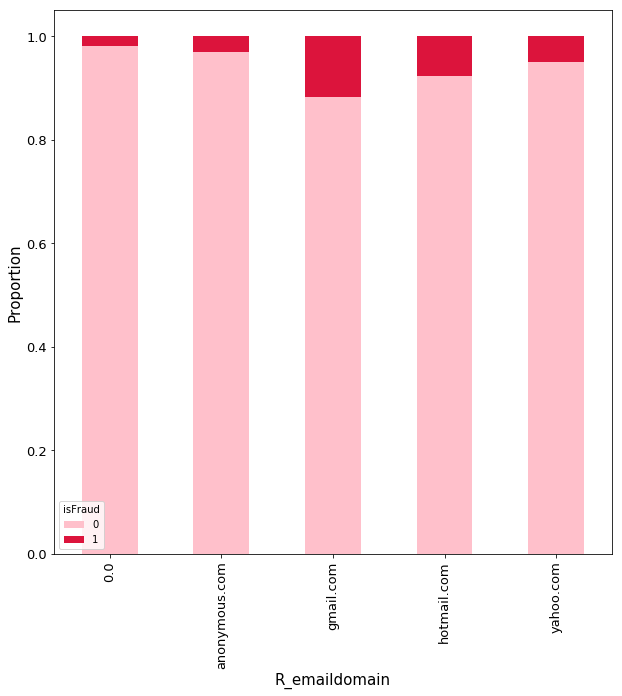

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

props = train_df.query("R_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com']").query("TransactionAmt < 500")\
                .groupby("R_emaildomain")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['pink', 'crimson'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

In the above proportion plot, the height of the dark red bar (at the top) represents the probability of a transaction received through a given email domain being fraudulent. We can see that an email domain of *gmail.com* is associated with the highest probability of a fraudulent transaction. The next most fraudulence-prone email domain is *hotmail.com*. And, the least fraudulence-prone email domain is *anonymous.com*.

### TransactionAmt vs. R_emaildomain  Violin Plot

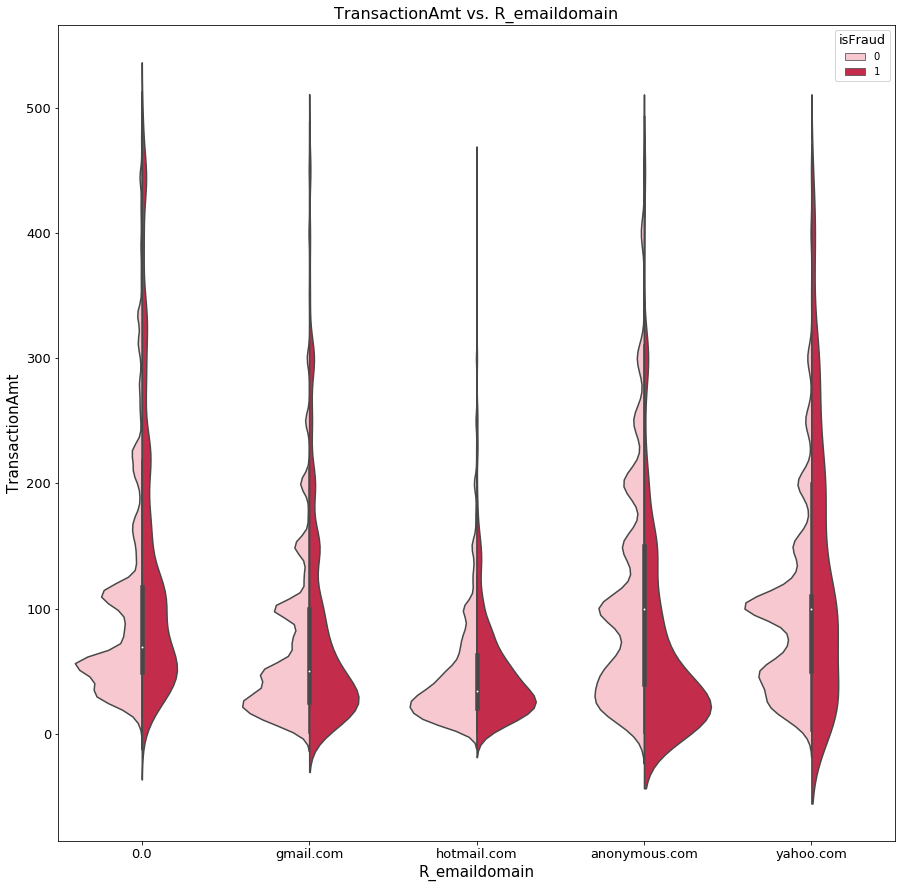

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="R_emaildomain", y="TransactionAmt", hue="isFraud",
                      data=train_df.query("R_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com']").query("TransactionAmt < 500"),
                      palette=['pink', 'crimson'], split=True, ax=ax).set_title('TransactionAmt vs. R_emaildomain', fontsize=16)

plt.show(plot)

In the above violin plots, the pink sections represent the distribution for non-fraudulent cases and the red sections represent the distribution for fraudulent cases. We can see the same trend as before. Both the distributions types have strong positive (leftward) skews. But, the pink (non-fraudulent) distributions have a greater probability density concentrated around the lower values of transaction amounts, once again, because there are several peaks (unlike the red distributions).

The exception to this trend is *anonymous.com*. The distributions for transaction amount (at *anonymous.com*) is much more skewed in the fraudulent case as compared to the non-fraudulent case. The other domains, namely, *gmail.com, yahoo.com, and hotmail.com* follow the general trend.

Each email domain's distributions are roughly concentrated around the same mean, but with differing variances. No single email domain has a much greater or lower mean than the other email domains.

Maybe, one can create a model that changes the weightage of the *TransactionAmt* feature based on the email domain. For example, the weightage of the *TransactionAmt* feature can be reduced for the *hotmail.com* email domain, because the fraudulent and non-fraudulent distributions are very similar for this email domain. 

### TransactionAmt vs. R_emaildomain  Box Plot

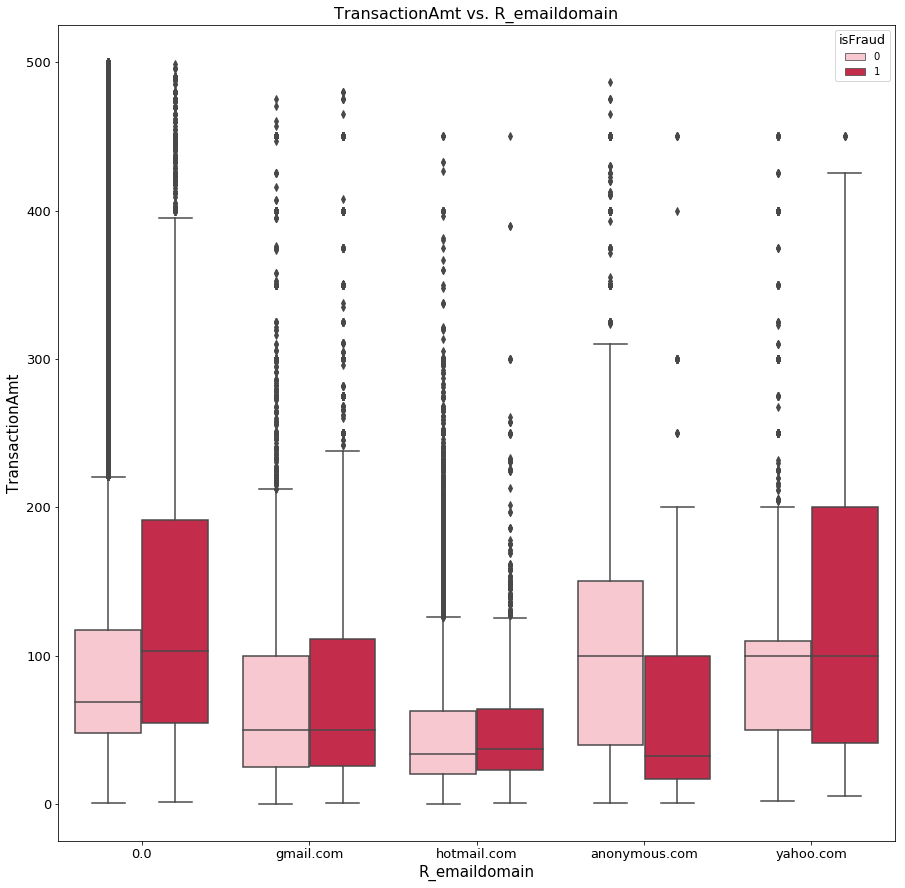

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="R_emaildomain", y="TransactionAmt", hue="isFraud",
                   data=train_df.query("R_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com']").query("TransactionAmt < 500"),
                   palette=['pink', 'crimson'], ax=ax).set_title('TransactionAmt vs. R_emaildomain', fontsize=16)

plt.show(plot)

The same trends and patterns can be seen in the box plots above. Both the distributions types have strong positive (leftward) skews. But, the light blue (non-fraudulent) distributions clearly have lower means as compared to the dark blue (fraudulent) distributions.

The same exceptions to this trend can also be seen in the above visualization. For example, at *anonymous.com*, the fraudulent distribution has a much lower mean than the non-fraudulent one (counterintuitively). Also, the non-fraudulent and fraudulent distributions are very similar for the *hotmail.com* email domain. Both the distributions have similar means, quartiles, minima, and maxima.

## Card brand (card4)

The card4 feature represents the brand of the card through which the transaction was made. The card brands in this dataset are *discover, mastercard, visa,* and *american express*.

### Frequencies of the different card brands

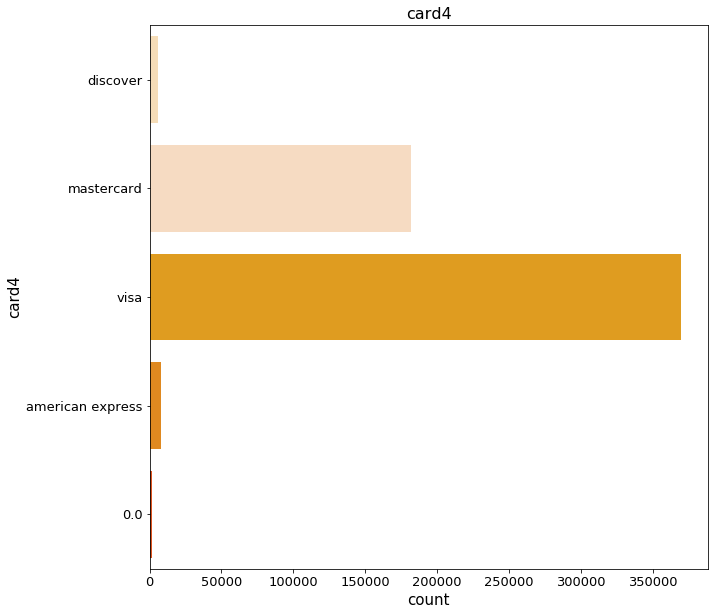

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="card4", data=train_df.query("TransactionAmt < 500"),
                     palette=reversed(['orangered', 'darkorange', 'orange', 'peachpuff', 'navajowhite'])).set_title('card4', fontsize=16)
plt.show(plot)

From the above plot, it is clear that the most common card brand used for transactions is *visa*. The second most common card brand is *mastercard*. The remaining two card brands, namely, *discover* and *american express* are very rare (comparatively).

### Fraudulence Proportion Plot

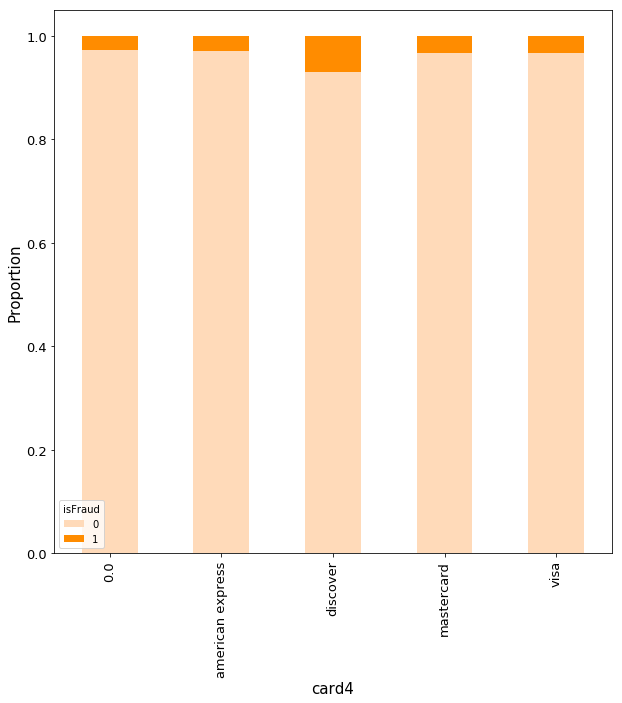

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

props = train_df.query("TransactionAmt < 500")\
                .groupby("card4")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['peachpuff', 'darkorange'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

In the above proportion plot, the height of the dark orange bar (at the top) represents the probability of a transaction received through a given card brand being fraudulent. We can see that *discover* cards are associated with the highest probability of a fraudulent transaction. The remaining card brands have a very similar fraudelence proportion.

### TransactionAmt vs. card4 Violin Plot 

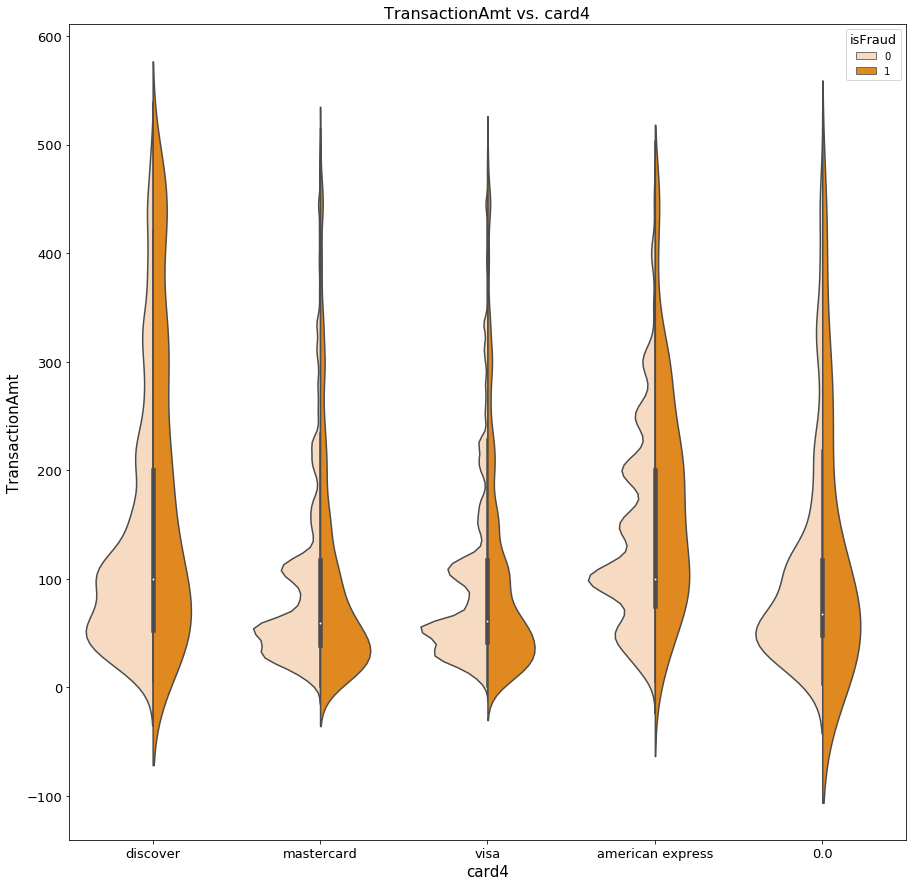

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="card4", y="TransactionAmt", hue="isFraud",
                      data=train_df.query("TransactionAmt < 500"),
                      palette=['peachpuff', 'darkorange'], split=True, ax=ax).set_title('TransactionAmt vs. card4', fontsize=16)

plt.show(plot)

In the above violin plots, the light orange sections represent the distribution for non-fraudulent cases and the dark orange sections represent the distribution for fraudulent cases. We can see the same trend as before. Both the distributions types have strong positive (leftward) skews. But, the light orange (non-fraudulent) distributions have a greater probability density concentrated around the lower values of transaction amounts, once again, because they have several peaks (unlike the dark orange distributions).

There do not seem to be any exceptions to this trend. The distributions for *american express* and *discover* cards seem to have higher means as compared to the other two card types. Therefore, more expensive transactions tend to take place through *american express* and *discover* cards.

### TransactionAmt vs. card4 Box Plot 

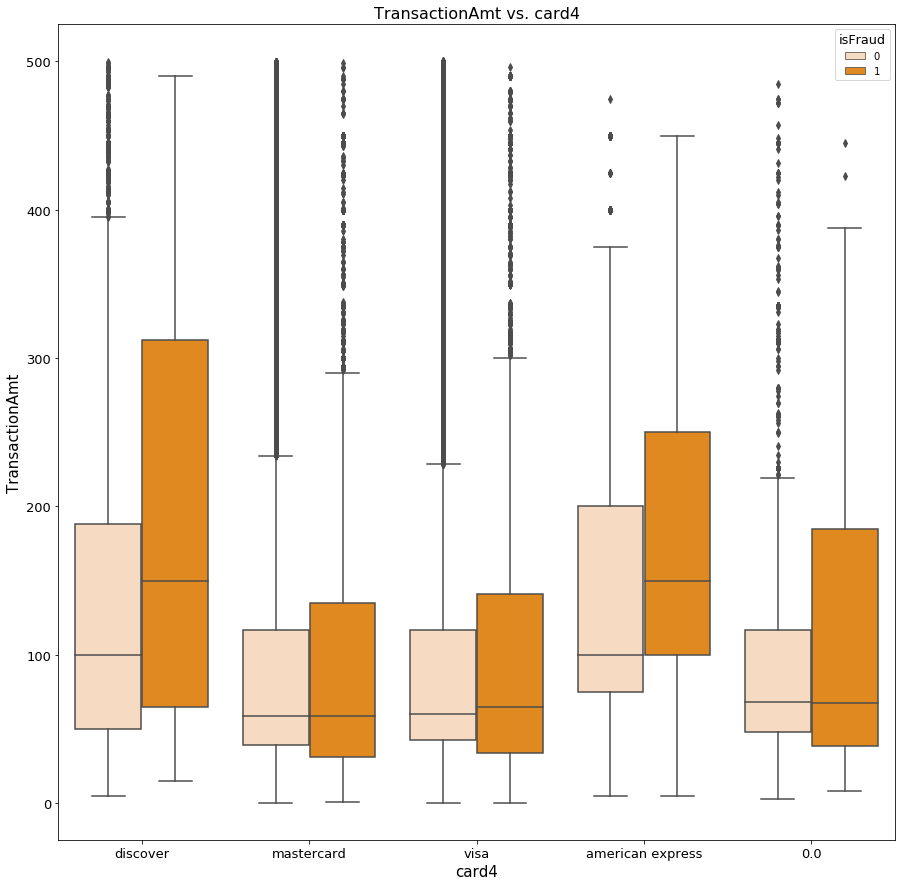

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="card4", y="TransactionAmt", hue="isFraud",
                   data=train_df.query("TransactionAmt < 500"),
                   palette=['peachpuff', 'darkorange'], ax=ax).set_title('TransactionAmt vs. card4', fontsize=16)

plt.show(plot)

In the box plot above, we can say that, for *mastercard* and *visa* cards, the fraudulent and non-fraudulent distributions are very similar. They have very similar means. It is also clear in this box plot, that *discover* and *american express* cards tend to be associated with higher transaction amounts. This can be inferred from the fact that they have much higher means as compared to the other two card brands.

## Card type (card6)

The card6 feature represents the btype of the card through which the transaction was made. The major card types in this dataset are *credit* and *debit*.

### Frequencies of the different card types

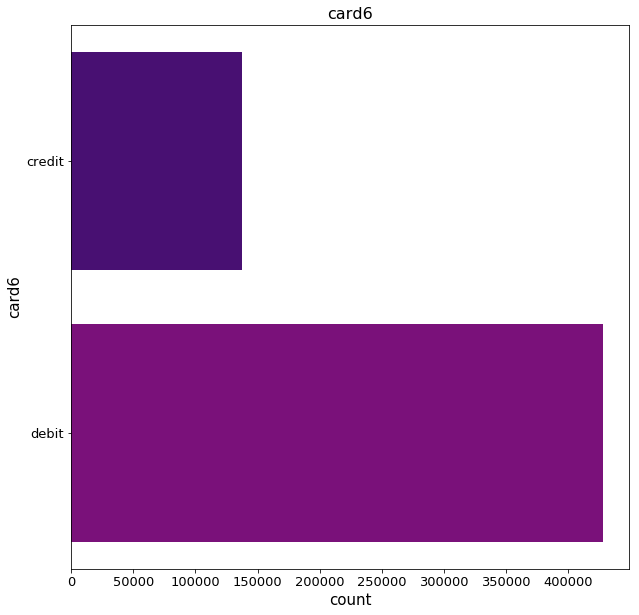

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="card6", data=train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'"),
                     palette=reversed(['red', 'crimson', 'mediumvioletred', 'darkmagenta', 'indigo'])).set_title('card6', fontsize=16)
plt.show(plot)

The two most common card types in this dataset are credit and debit (the rest are comparatively negligible). Debit cards are more common than credit cards in this dataset.

### Fraudulence Proportion Plot

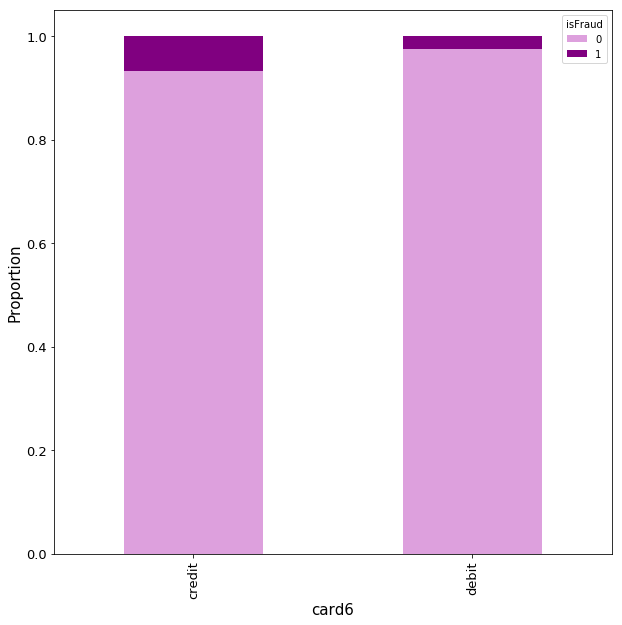

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

props = train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'")\
                .groupby("card6")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['plum', 'purple'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

In the above proportion plot, the height of the dark purple bar (at the top) represents the probability of a transaction received through a given card type being fraudulent. We can see that a given *credit* card is more likely involved in a fraudulent transaction as compared to a given *debit card*.

### TransactionAmt vs. card6 Violin Plot

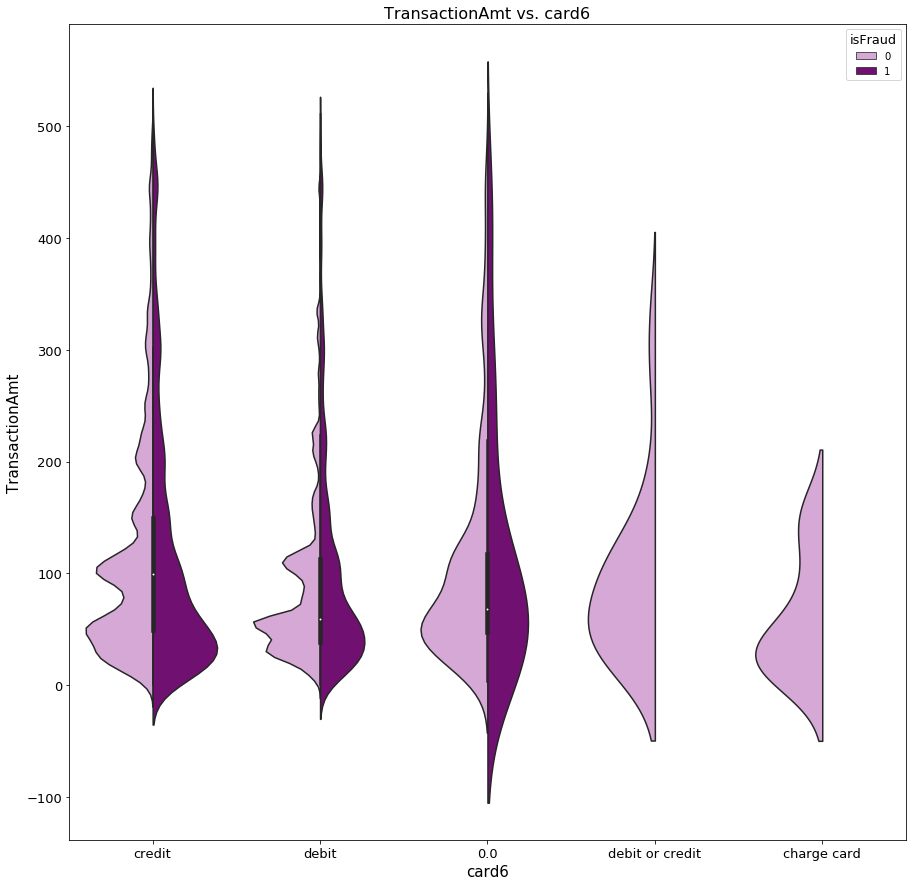

In [27]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="card6", y="TransactionAmt", hue="isFraud",
                      data=train_df.query("TransactionAmt < 500"),
                      palette=['plum', 'purple'], split=True, ax=ax).set_title('TransactionAmt vs. card6', fontsize=16)

plt.show(plot)

In the above violin plots, the light purple sections represent the distribution for non-fraudulent cases and the dark purple sections represent the distribution for fraudulent cases. We can see the same trend as before. Both the distributions types have strong positive (leftward) skews. But, the light purple (non-fraudulent) distributions have a greater probability density concentrated around the lower values of transaction amounts, once again, because they have several peaks (unlike the dark purple distributions).

In the above violin plot, it can be seen that debit cards cards are associated with lower transaction amounts as compared to credit cards because their distributions have stronger positive (leftward) skew. Also, the credit card distributions have higher means.

### TransactionAmt vs. card6 Box Plot

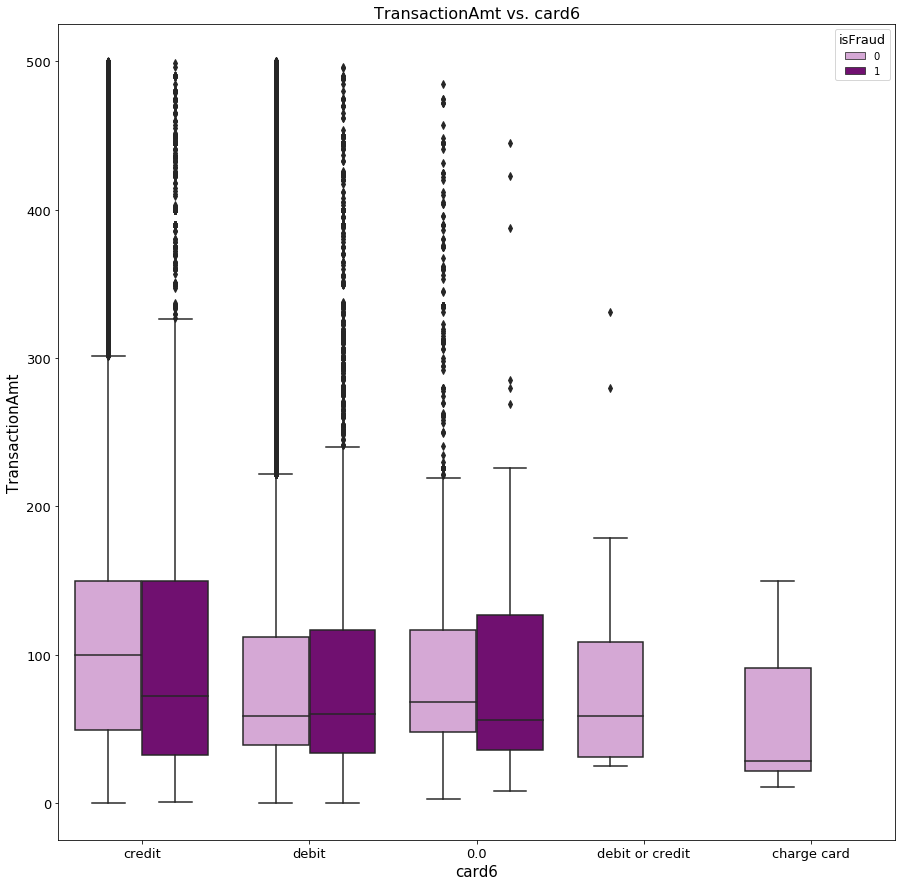

In [28]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="card6", y="TransactionAmt", hue="isFraud",
                   data=train_df.query("TransactionAmt < 500"),
                   palette=['plum', 'purple'], ax=ax).set_title('TransactionAmt vs. card6', fontsize=16)

plt.show(plot)

In the box plot above, we can see that credit cards are associated with much higher mean transaction amounts as compared to debit cards. 

## "M" Features

I am not sure about the meanings of these features (M1, M2, and so on till M9), but the competition overview states that these are categorical features.

### Fraudulence Proportion Plots of "M" features

### M1

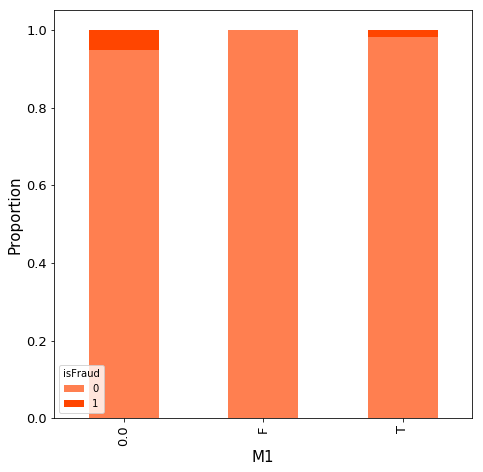

In [29]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

props = train_df.query("TransactionAmt < 500")\
                .groupby("M1")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['coral', 'orangered'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

From the above proportion plot, it can be seen that the most fraudulence prone M1 value is 0.0. This is because all the NaN values were converted to 0s in the beginning. Therefore, an undefined M1 value has the highest chance of being fraudulent. Besides this, a sample with an M1 value of T has a much higher chance of being fraudulent than one with an M1 value of F.

### M2

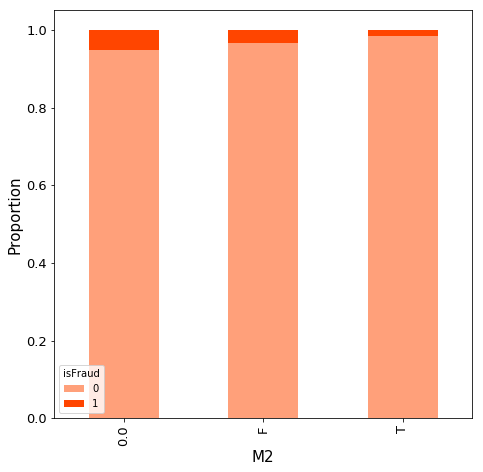

In [30]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

props = train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'")\
                .groupby("M2")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['lightsalmon', 'orangered'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

From the above proportion plot, it can be seen that the most fraudulence prone M2 value is 0.0. This is because all the NaN values were converted to 0s in the beginning. Therefore, an undefined M2 value has the highest chance of being fraudulent. Besides this, a sample with an M2 value of F has a much higher chance of being fraudulent than one with an M2 value of T.

### M3

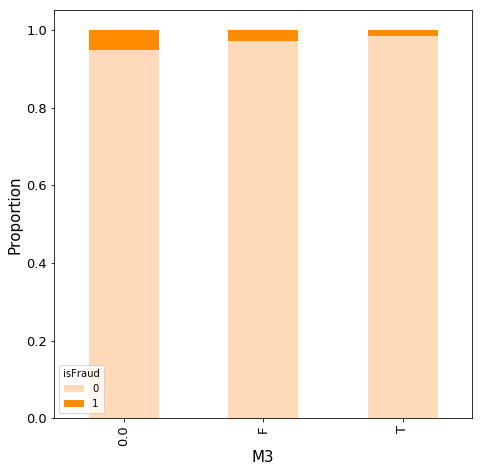

In [31]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

props = train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'")\
                .groupby("M3")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['peachpuff', 'darkorange'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

From the above proportion plot, it can be seen that the most fraudulence prone M3 value is 0.0. This is because all the NaN values were converted to 0s in the beginning. Therefore, an undefined M3 value has the highest chance of being fraudulent. Besides this, a sample with an M3 value of F has a much higher chance of being fraudulent than one with an M3 value of T.

### M4

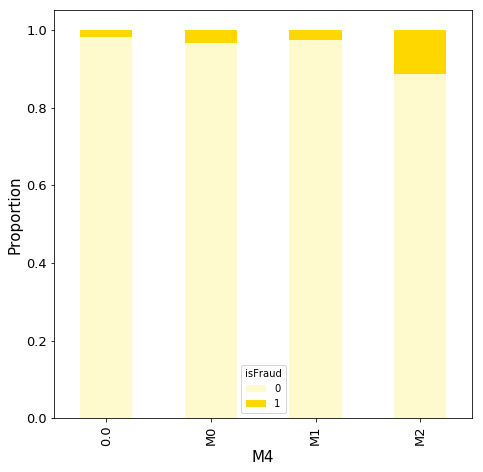

In [32]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

props = train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'")\
                .groupby("M4")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['lemonchiffon', 'gold'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

From the above proportion plot, it can be seen that a that a sample with an M4 value of M2 has a much higher chance of being fraudulent than one with an M4 value of M0. Also, a sample with an M4 value of M0 has a higher chance of being fraudulent than one with an M4 value of M1. An M4 value of 0.0 (or NaN) has the lowest chance of being fraudulent.

### M5

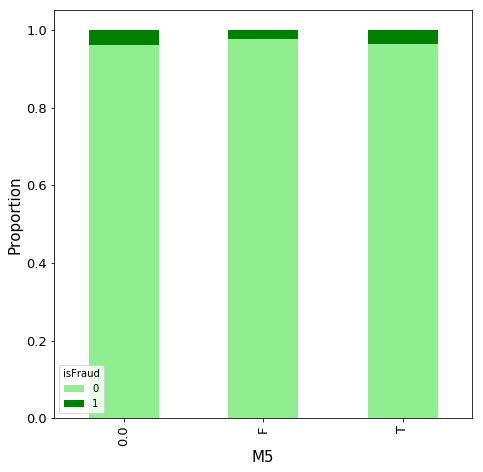

In [33]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

props = train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'")\
                .groupby("M5")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['lightgreen', 'green'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

From the above proportion plot, it can be seen that the most fraudulence prone M5 value is 0.0. This is because all the NaN values were converted to 0s in the beginning. Therefore, an undefined M5 value has the highest chance of being fraudulent. Besides this, a sample with an M5 value of T has a much higher chance of being fraudulent than one with an M5 value of F.

### M6

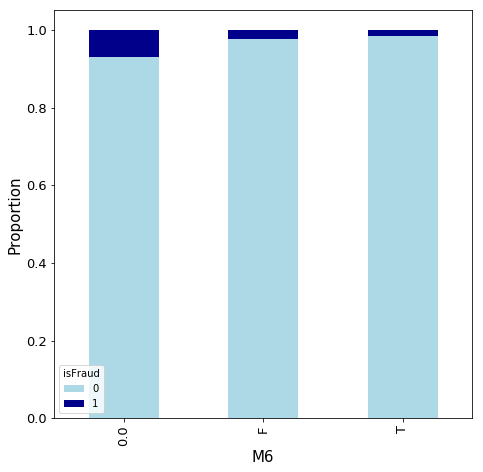

In [34]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

props = train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'")\
                .groupby("M6")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['lightblue', 'darkblue'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

From the above proportion plot, it can be seen that the most fraudulence prone M6 value is 0.0. This is because all the NaN values were converted to 0s in the beginning. Therefore, an undefined M6 value has the highest chance of being fraudulent. Besides this, a sample with an M6 value of F has a much higher chance of being fraudulent than one with an M6 value of T.

### M7

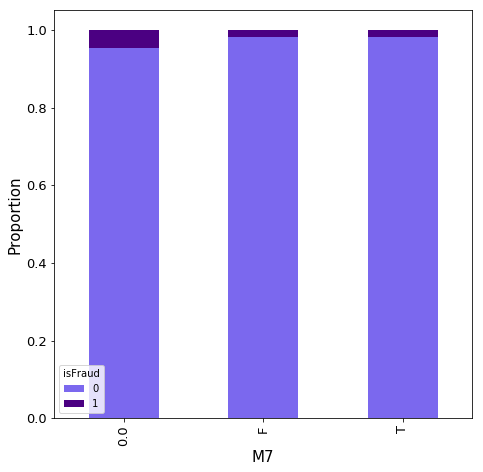

In [35]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

props = train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'")\
                .groupby("M7")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['mediumslateblue', 'indigo'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

From the above proportion plot, it can be seen that the most fraudulence prone M7 value is 0.0. This is because all the NaN values were converted to 0s in the beginning. Therefore, an undefined M7 value has the highest chance of being fraudulent. Besides this, a sample with an M7 value of F has a very similar chance of being fraudulent to one with an M7 value of T.

### M8

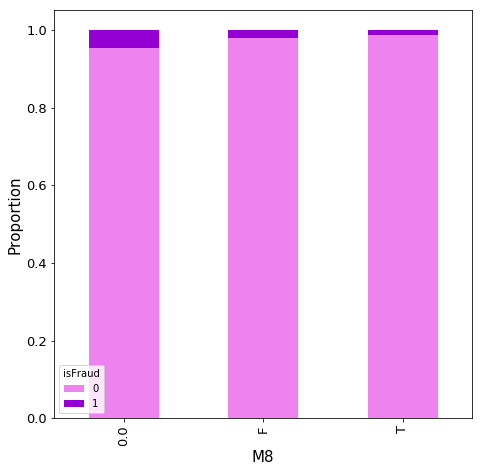

In [36]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

props = train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'")\
                .groupby("M8")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['violet', 'darkviolet'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

From the above proportion plot, it can be seen that the most fraudulence prone M8 value is 0.0. This is because all the NaN values were converted to 0s in the beginning. Therefore, an undefined M8 value has the highest chance of being fraudulent. Besides this, a sample with an M8 value of T has a very similar chance of being fraudulent to one with an M8 value of F.

### M9

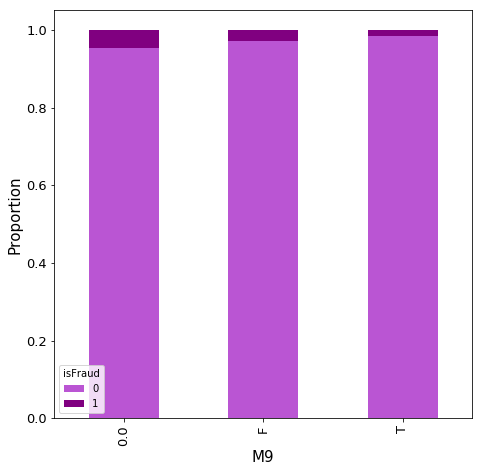

In [37]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

props = train_df.query("TransactionAmt < 500").query("card6 == 'credit' or card6 == 'debit'")\
                .groupby("M9")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['mediumorchid', 'purple'])
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
plt.show(plot)

From the above proportion plot, it can be seen that the most fraudulence prone M9 value is 0.0. This is because all the NaN values were converted to 0s in the beginning. Therefore, an undefined M9 value has the highest chance of being fraudulent. Besides this, a sample with an M9 value of F has a much higher chance of being fraudulent than one with an M9 value of T.

# Modeling

## Preparing the training and testing data

### Define the categorical columns

In [38]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15',
            'id_16', 'id_17', 'id_18', 'id_19',
            'id_20', 'id_21','id_22', 'id_23',
            'id_24', 'id_25', 'id_26', 'id_27',
            'id_28', 'id_29', 'id_30', 'id_31',
            'id_32', 'id_33', 'id_34', 'id_35',
            'id_36', 'id_37', 'id_38',
            'DeviceType', 'DeviceInfo', 'ProductCD', 
            'card4', 'card6', 'M4', 'P_emaildomain',
            'R_emaildomain','card1', 'card2', 'card3', 'card5', 'addr1',
            'addr2', 'M1', 'M2', 'M3', 'M5', 'M6','M7', 'M8', 'M9', 
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3',
            'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']

cat_cols = [col for col in cat_cols if col in train_df.columns]

### Convert categorical string data into numerical format

In [39]:
def prepare_data(df, cat_cols=cat_cols):
    cat_cols = [col for col in cat_cols if col in df.columns]
    for col in tqdm(cat_cols):\
        df[col] = pd.factorize(df[col])[0]
    return df

In [40]:
train_data = prepare_data(train_df)
test_data = prepare_data(test_df)

### Create final train and validation arrays

In [41]:
X = train_data.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train_data.sort_values('TransactionDT')['isFraud']
del train_data

In [42]:
split = np.int32(0.8 * len(X))
X_train = X[:split]
y_train = np.int32(y)[:split]
X_val = X[split:]
y_val = np.int32(y)[split:]

## LightGBM

### Build and train LightGBM model

In [43]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

train_data = lightgbm.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
val_data = lightgbm.Dataset(X_val, label=y_val)

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.822151
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.845235
[3]	valid_0's auc: 0.856642
[4]	valid_0's auc: 0.859842
[5]	valid_0's auc: 0.861856
[6]	valid_0's auc: 0.862666
[7]	valid_0's auc: 0.865799
[8]	valid_0's auc: 0.865505
[9]	valid_0's auc: 0.867545
[10]	valid_0's auc: 0.868832
[11]	valid_0's auc: 0.870501
[12]	valid_0's auc: 0.871908
[13]	valid_0's auc: 0.873455
[14]	valid_0's auc: 0.875059
[15]	valid_0's auc: 0.875797
[16]	valid_0's auc: 0.876721
[17]	valid_0's auc: 0.877375
[18]	valid_0's auc: 0.878216
[19]	valid_0's auc: 0.879025
[20]	valid_0's auc: 0.879296
[21]	valid_0's auc: 0.880534
[22]	valid_0's auc: 0.881617
[23]	valid_0's auc: 0.882657
[24]	valid_0's auc: 0.883019
[25]	valid_0's auc: 0.883767
[26]	valid_0's auc: 0.884001
[27]	valid_0's auc: 0.88427
[28]	valid_0's auc: 0.884686
[29]	valid_0's auc: 0.884846
[30]	valid_0's auc: 0.88529
[31]	valid_0's auc: 0.886247
[32]	valid_0's auc: 0.886572
[33]	valid_0's auc: 

**This trained model can be used to make predictions on the training data using:**

> model.predict(X_test)

### Visualize feature importances

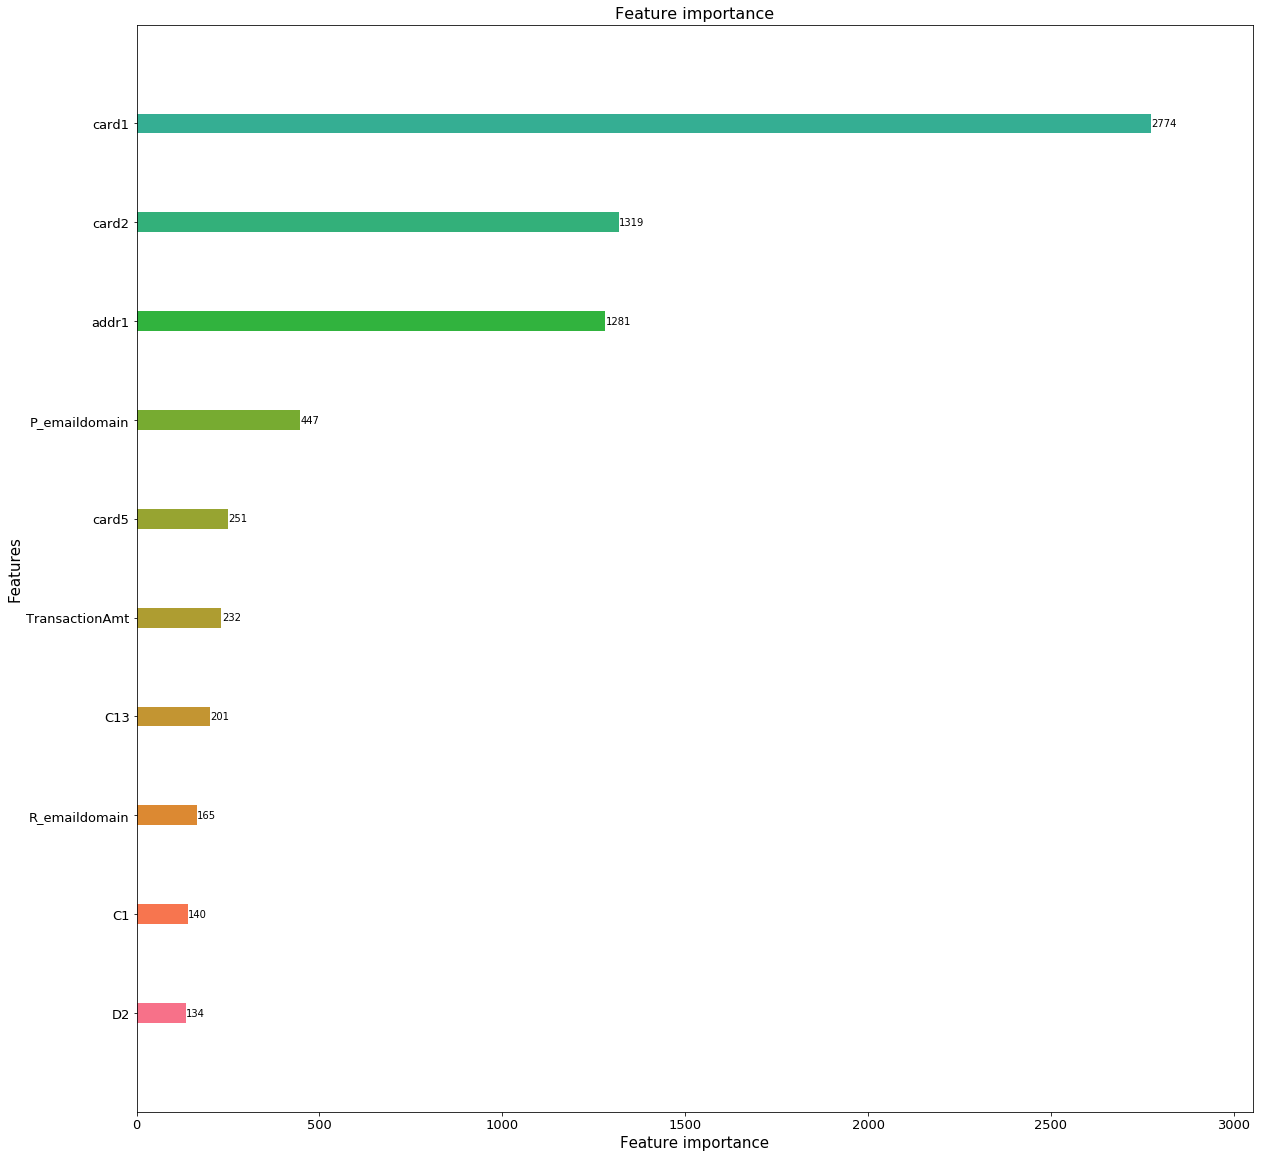

In [44]:
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["ytick.labelsize"] = 13

plot = lightgbm.plot_importance(model, max_num_features=10, figsize=(20, 20), grid=False, color=sns.color_palette("husl", 20))
plt.show(plot)

The above diagram ranks the features based on importance. The features given the most weightage during prediction are considered more "important". The features at the top are the most important and the ones at the bottom are the least important for this LightGBM model.

## Neural Networks

### Build Neural Network model

This is a simple neural network model that consists of two hidden layers with 10 neurons each. The activation function used is ReLU and the activation function for the last layer is sigmoid because a probability between 0 and 1 needs to given as output.

**Steps:**

* Pass the input vector through a dense layer with 10 neurons
* Pass the output of that layer through another dense layer with 10 neurons
* Finally, pass the output of the previous layer through a dense layer with one neuron with a sigmoid activation function (to output a probability between 0 and 1)

In [45]:
def get_neural_network():
    inputs = Input(shape=(X.shape[1],))
    dense_1 = Dense(10, activation='relu')(inputs)
    dense_2 = Dense(10, activation='relu')(dense_1)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

### Check model summary

In [46]:
model = get_neural_network()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 391)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3920      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 4,041
Trainable params: 4,041
Non-trainable params: 0
_________________________________________________________________


### Visualize the model architecture

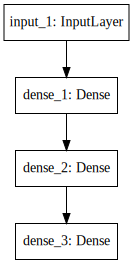

In [47]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train the Neural Network

In [48]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)

Train on 472432 samples, validate on 118108 samples
Epoch 1/5
472432/472432 [==============================] - 27s 57us/step - loss: 0.1616 - acc: 0.9665 - val_loss: 0.1203 - val_acc: 0.9689
Epoch 2/5
472432/472432 [==============================] - 26s 56us/step - loss: 0.1189 - acc: 0.9696 - val_loss: 0.1193 - val_acc: 0.9697
Epoch 3/5
472432/472432 [==============================] - 27s 57us/step - loss: 0.1160 - acc: 0.9706 - val_loss: 0.1149 - val_acc: 0.9706
Epoch 4/5
472432/472432 [==============================] - 26s 56us/step - loss: 0.1135 - acc: 0.9711 - val_loss: 0.1149 - val_acc: 0.9699
Epoch 5/5
472432/472432 [==============================] - 26s 55us/step - loss: 0.1128 - acc: 0.9714 - val_loss: 0.1121 - val_acc: 0.9710


**This trained model can be used to make predictions on the training data using:**

> model.predict(X_test)

### Visualize change in accuracy

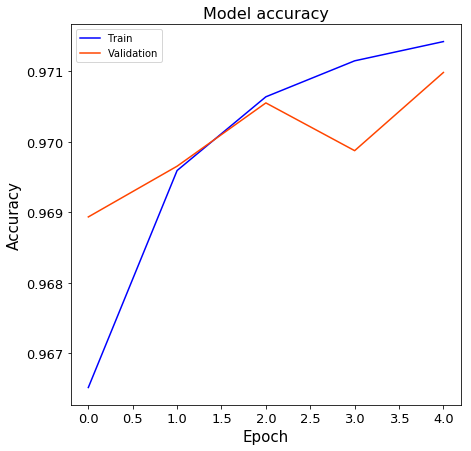

In [49]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['val_acc'], color='orangered')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

It can be clearly seen from the above plot that the training and validation accuracies are increasing as the training process proceeds.

### Visualize change in loss

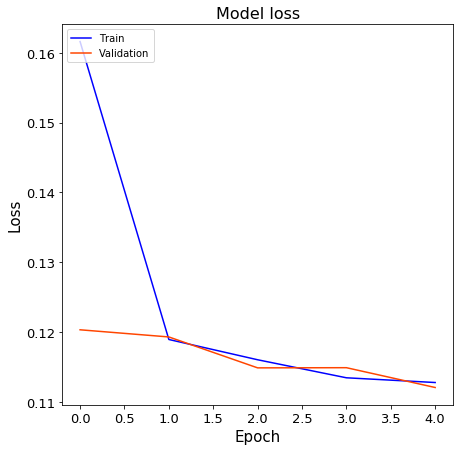

In [50]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='orangered')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

It can be clearly seen from the above plot that the training and validation losses (binary cross-entropy) are decreasing as the training process proceeds.

In [51]:
print("Thank you!")

Thank you!


# Ending note

This concludes my EDA and modeling kernel. I hope that this kernel was helpful for you to understand the data better. Please post any feedback or comments regarding this kernel below in the comments section.

**Thanks for reading this kernel and please don't forget to upvote if you liked it :)**

